<a href="https://colab.research.google.com/github/PranjaliNMore/2121_wave_cafe/blob/main/%20ElectricVehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 0 — required packages
# Run in your notebook once: (uncomment if you need to install)
# !pip install scikit-learn xgboost shap streamlit matplotlib pandas

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: import shap when ready (can be heavy)
# import shap


In [ ]:
# Step 1 — Load dataset
DATA_PATH = '/content/sample_data/electric_vehicles_dataset.csv'   # already uploaded in your environment
assert os.path.exists(DATA_PATH), "Change DATA_PATH to where the CSV is stored."

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(6))


Shape: (3022, 17)


,Vehicle_ID,Manufacturer,Model,Year,Battery_Type,Battery_Capacity_kWh,Range_km,Charging_Type,Charge_Time_hr,Price_USD,Color,Country_of_Manufacture,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years
0,1,Acura,ZDX (with GM Ultium),2015,Lithium-titanate,55.8,214,CHAdeMO,9.0,111203.94,Matte White,UK,0.0,NaN,5.0,19726,3
1,2,Lamborghini,Revuelto (PHEV),2025,Lithium-titanate,90.8,212,Vehicle-to-Home (V2H),7.3,127131.65,White,Netherlands,2.0,0.0,4.0,3349,3
2,3,NIO,ET7,2020,Calcium-ion,64.7,235,Level 2 Charging,8.9,94347.37,Beige,UK,5.0,0.0,5.0,6300,5
3,4,Audi,e-tron,2025,Lithium-iron phosphate,120.5,140,Ultra-Fast Charging (350 kW+),10.5,75615.15,Sunset Orange,Argentina,2.0,0.0,5.0,2339,5
4,5,Acura,ZDX (with GM Ultium),2023,Lithium-titanate,51.8,336,Plug-in Hydrogen Refueling,3.6,141046.94,Ice Silver,United Arab Emirates,2.0,0.0,3.0,1051,4
5,6,XPeng,G9,2016,Lithium-iron phosphate,138.7,390,Mobile Charging,2.9,89907.75,Ruby Red,Australia,NaN,NaN,5.0,8609,5


In [ ]:
# Step 2 — Quick summary and missing values
print("Columns and dtypes:")
print(df.dtypes)

print("\nMissing values (count):")
display(df.isna().sum().sort_values(ascending=False).head(50))

print("\nBasic numeric describe:")
display(df.describe().T)


Columns and dtypes:
Vehicle_ID                  int64
Manufacturer               object
Model                      object
Year                        int64
Battery_Type               object
Battery_Capacity_kWh      float64
Range_km                    int64
Charging_Type              object
Charge_Time_hr            float64
Price_USD                 float64
Color                      object
Country_of_Manufacture     object
Autonomous_Level          float64
CO2_Emissions_g_per_km    float64
Safety_Rating             float64
Units_Sold_2024             int64
Warranty_Years              int64
dtype: object

Missing values (count):


,0
CO2_Emissions_g_per_km,592
Autonomous_Level,442
Safety_Rating,337
Vehicle_ID,0
Manufacturer,0
Battery_Capacity_kWh,0
Model,0
Year,0
Battery_Type,0
Charge_Time_hr,0



Basic numeric describe:


,count,mean,std,min,25%,50%,75%,max
Vehicle_ID,3022.0,1511.500000,872.520582,1.00,756.250,1511.500,2266.7500,3022.00
Year,3022.0,2020.019523,3.132083,2015.00,2017.000,2020.000,2023.0000,2025.00
Battery_Capacity_kWh,3022.0,84.314692,37.210461,20.00,52.425,83.600,115.8000,150.00
Range_km,3022.0,349.901059,145.406139,100.00,222.000,347.000,478.0000,600.00
Charge_Time_hr,3022.0,6.212045,3.350597,0.50,3.300,6.200,9.1000,12.00
Price_USD,3022.0,90611.906760,34654.533838,30014.46,61257.390,90929.705,120199.8425,149978.53
Autonomous_Level,2580.0,2.519380,1.713712,0.00,1.000,3.000,4.0000,5.00
CO2_Emissions_g_per_km,2430.0,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
Safety_Rating,2685.0,3.995158,0.819594,3.00,3.000,4.000,5.0000,5.00
Units_Sold_2024,3022.0,10207.072799,5771.619003,6.00,5145.500,10350.000,15128.0000,19996.00


In [ ]:
# Step 3 — Choose target column automatically (or set manually)
# Heuristics: look for 'sales','price','range','units' in column names
candidates = [c for c in df.columns if any(k in c.lower() for k in ('sales','price','range','units','sale'))]
print("Candidates:", candidates)

if len(candidates) > 0:
    target = candidates[0]   # automatic pick; change if you prefer a different target
else:
    # fallback: choose the last numeric column
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    assert len(numeric_cols)>0, "No numeric columns found—specify target manually."
    target = numeric_cols[-1]

print("Using target =", target)


Candidates: ['Range_km', 'Price_USD', 'Units_Sold_2024']
Using target = Range_km


In [ ]:
# Step 4 — Simple cleaning
df_clean = df.copy()

# drop columns that are fully empty
empty_cols = [c for c in df_clean.columns if df_clean[c].isna().all()]
if empty_cols:
    df_clean.drop(columns=empty_cols, inplace=True)
    print("Dropped fully-empty columns:", empty_cols)

# drop duplicates
before = len(df_clean)
df_clean.drop_duplicates(inplace=True)
print("Dropped duplicates:", before - len(df_clean))

# drop rows missing target
if df_clean[target].isna().sum() > 0:
    print("Dropping rows with missing target:", df_clean[target].isna().sum())
    df_clean = df_clean[df_clean[target].notna()]


Dropped duplicates: 0


In [ ]:
# Step 5 — Feature typing: detect numeric/categorical, handle high-cardinality cats
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# If target is numeric it's included in num_cols — remove it for features list
if target in num_cols:
    num_features = [c for c in num_cols if c!=target]
else:
    num_features = num_cols.copy()

# Drop extremely high-cardinality categories (or treat them specially)
high_card = [c for c in cat_cols if df_clean[c].nunique() > 50]
if high_card:
    print("High-cardinality categorical columns (consider special encoding or drop):", high_card)
    # For this notebook we will drop them — change if you want to use target encoding etc.
    df_clean.drop(columns=high_card, inplace=True)
    cat_cols = [c for c in cat_cols if c not in high_card]

print("Numeric features:", num_features[:10])
print("Categorical features:", cat_cols[:10])


High-cardinality categorical columns (consider special encoding or drop): ['Manufacturer', 'Model', 'Color']
Numeric features: ['Vehicle_ID', 'Year', 'Battery_Capacity_kWh', 'Charge_Time_hr', 'Price_USD', 'Autonomous_Level', 'CO2_Emissions_g_per_km', 'Safety_Rating', 'Units_Sold_2024', 'Warranty_Years']
Categorical features: ['Battery_Type', 'Charging_Type', 'Country_of_Manufacture']


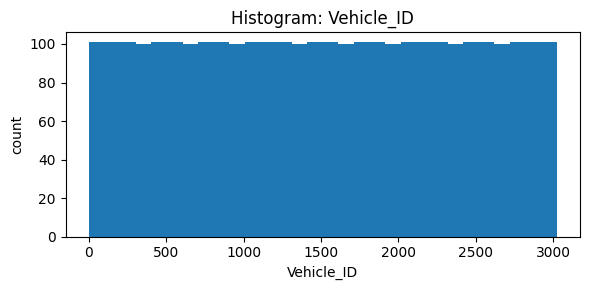

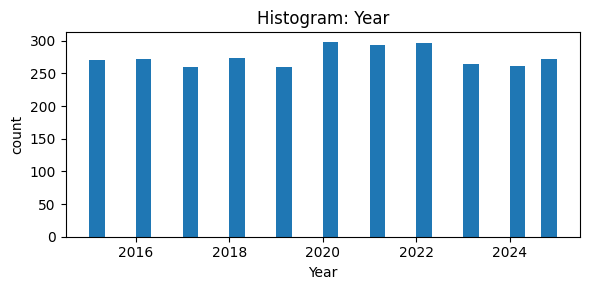

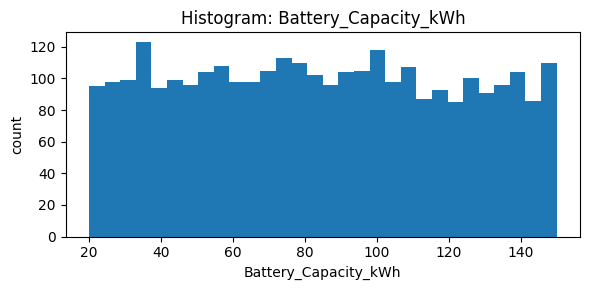

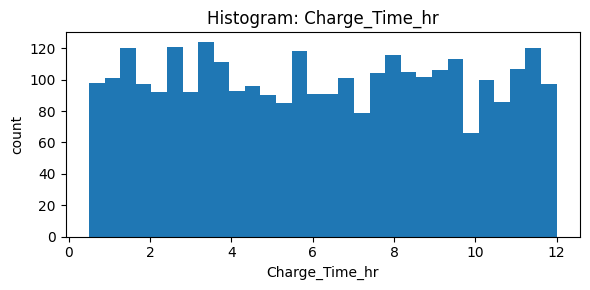

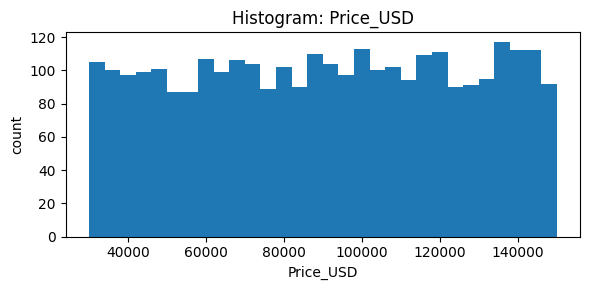

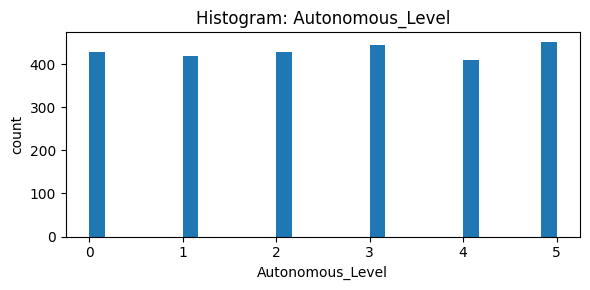

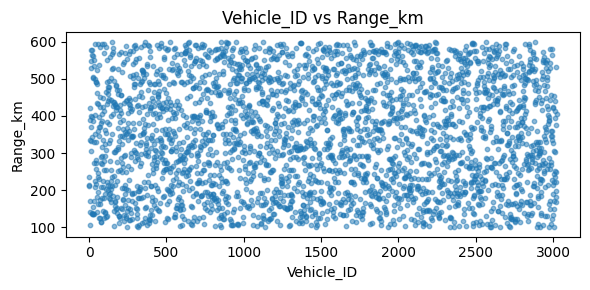

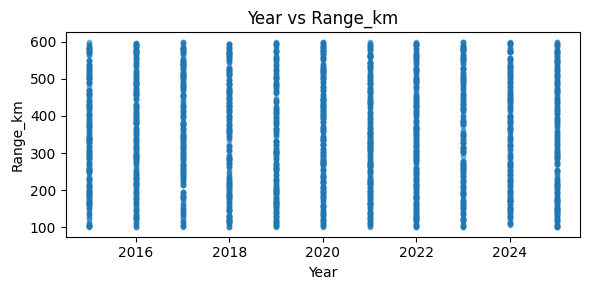

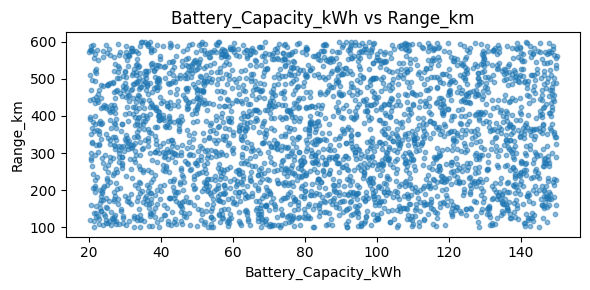

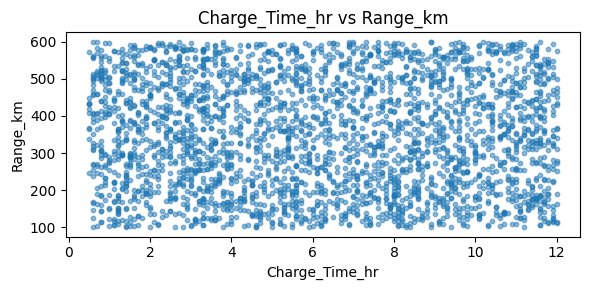

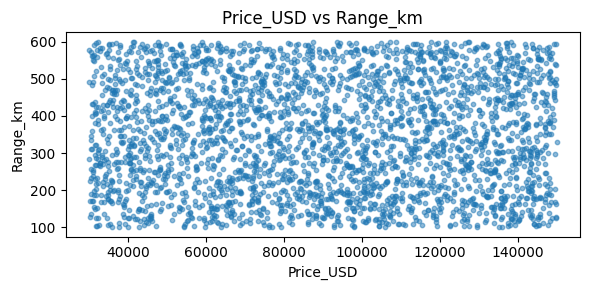

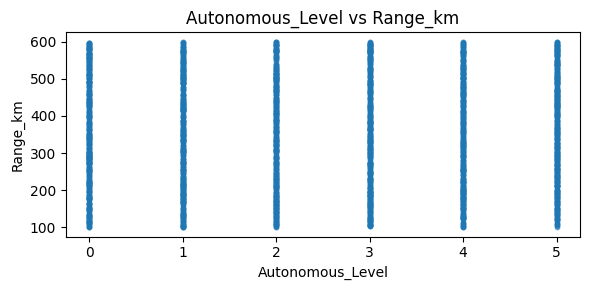

,Range_km
Range_km,1.000000
Vehicle_ID,0.015644
Autonomous_Level,0.014562
Warranty_Years,0.014174
Units_Sold_2024,0.013507
Battery_Capacity_kWh,-0.001871
Price_USD,-0.007748
Safety_Rating,-0.009137
Year,-0.024297
Charge_Time_hr,-0.025931


In [ ]:
# Step 6 — Exploratory Data Analysis (light)
# NOTE: plotting many charts can be slow. Below are a few compact plots.
sample_num_cols = num_features[:6]  # limit to first 6 numeric features for speed

for col in sample_num_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df_clean[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Scatter target vs a few numeric features
for col in sample_num_cols:
    plt.figure(figsize=(6,3))
    plt.scatter(df_clean[col], df_clean[target], alpha=0.5, s=10)
    plt.title(f"{col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# Correlation (numeric)
if len(num_features) >= 2:
    corr = df_clean[[*num_features, target]].corr()
    display(corr[target].sort_values(ascending=False).head(20))  # show top correlations with target


In [ ]:
# Step 7 — Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


In [ ]:
# Step 8 — Train/test split (random). If your target is time-series, use time-split instead.
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (2417, 13) (605, 13)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 9 — Baseline models: LinearRegression and RandomForest (pipeline includes preprocessor)
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Fit and evaluate Linear Regression
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
print("LinearRegression RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("LinearRegression MAE:", mean_absolute_error(y_test, pred_lr))
print("LinearRegression R2:", r2_score(y_test, pred_lr))

# Fit and evaluate Random Forest
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("RandomForest MAE:", mean_absolute_error(y_test, pred_rf))
print("RandomForest R2:", r2_score(y_test, pred_rf))


LinearRegression RMSE: 146.23399149693483
LinearRegression MAE: 126.04237910159958
LinearRegression R2: -0.05780717835816529
RandomForest RMSE: 145.47836828477853
RandomForest MAE: 125.62670247933885
RandomForest R2: -0.04690357707025394


In [ ]:
# Step 10 — Cross-Validation (quick)
cv_scores = cross_val_score(pipe_rf, X, y, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("RF CV RMSEs:", -cv_scores, " mean:", -cv_scores.mean())


RF CV RMSEs: [148.11185453 147.27323801 148.82264565]  mean: 148.06924606215784


In [ ]:
# Step 11 — Feature importances (for RandomForest)
# We need the post-preprocessing feature names. Use helper to extract them.
def get_feature_names_from_preprocessor(preprocessor):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            # OneHotEncoder present
            ohe = transformer.named_steps['onehot']
            cols = list(ohe.get_feature_names_out(columns))
            feature_names.extend(cols)
    return feature_names

feature_names = get_feature_names_from_preprocessor(preprocessor)
print("Number of features after preprocessing:", len(feature_names))
# Get RF importances
rf = pipe_rf.named_steps['model']
if hasattr(rf, 'feature_importances_'):
    fi = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
    display(fi.head(30))
else:
    print("No feature_importances_ available.")


Number of features after preprocessing: 81


,0
Battery_Capacity_kWh,0.113364
Vehicle_ID,0.112082
Units_Sold_2024,0.111640
Price_USD,0.111162
Charge_Time_hr,0.095475
Year,0.054261
Autonomous_Level,0.038968
Safety_Rating,0.021446
Warranty_Years,0.021159
Battery_Type_Zinc-air,0.007259


In [17]:
# Step 12 — SHAP explainability (optional; install shap and run)
# SHAP can be heavy. Use a small sample if you run it.
try:
    import shap
    print("SHAP available. Computing SHAP values on a small sample (<=200 rows).")
    sample = X_test.sample(n=min(200, X_test.shape[0]), random_state=1)
    # transform inputs to numeric matrix via preprocessor
    sample_trans = preprocessor.fit_transform(X_train)  # ensure preprocessor fitted on training set
    # BUT shap for scikit-learn RF expects raw model; we can use TreeExplainer on rf with preprocessed features:
    sample_X_pre = preprocessor.transform(sample)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(sample_X_pre)
    # Summary plot (matplotlib)
    shap.summary_plot(shap_values, sample_X_pre, feature_names=feature_names)
except Exception as e:
    print("SHAP not run:", e)
    # If shap missing, run: pip install shap and rerun this cell.


SHAP available. Computing SHAP values on a small sample (<=200 rows).
SHAP not run: name 'X_test' is not defined


In [ ]:
# Step 14 — Save the best pipeline (either tuned or earlier RF)
final_pipeline = best_model if 'best_model' in locals() else pipe_rf
save_path = '/content/sample_data/electric_vehicles_dataset.csv'
with open(save_path, 'wb') as f:
    pickle.dump(final_pipeline, f)
print("Saved pipeline to:", save_path)



Saved pipeline to: /content/sample_data/electric_vehicles_dataset.csv


In [6]:
# Step 15 — Streamlit app skeleton (for EV Battery Capacity Prediction)

import pandas as pd
import pickle

# 🧩 Define your numeric feature columns (edit names if needed)
num_features = [
    'Battery_Temperature', 'Charge_Cycles', 'Voltage', 'Current',
    'Ambient_Temperature', 'Usage_Hours', 'Charging_Time', 'Discharging_Time'
]

# 🎯 Define target variable
target = 'Battery_Capacity'

# 🧱 Create app structure
app_code = f'''
import streamlit as st
import pickle
import pandas as pd

# Load trained model
model = pickle.load(open("best_model_pipeline.pkl","rb"))
st.title("EV {target} Predictor - Demo")

st.write("Auto-generated skeleton. Edit inputs to match your dataset features.")

def make_input():
    d = {{}}
'''

# ➕ Add input widgets for numeric features
for col in num_features[:12]:
    app_code += f"    d['{col}'] = st.number_input('{col}', value=0.0)\n"

# 🧾 Generate prediction section
app_code += f'''
    return pd.DataFrame([d])

df = make_input()
if st.button('Predict'):
    pred = model.predict(df)[0]
    st.metric('Predicted {target}:', round(pred, 2))
'''

# 💾 Save the Streamlit app file
with open('/content/streamlit_app_skeleton.py','w') as f:
    f.write(app_code)

print("✅ Streamlit app saved to /content/streamlit_app_skeleton.py")
print("👉 Run this in your terminal (where the model file exists):")
print("   streamlit run streamlit_app_skeleton.py")



✅ Streamlit app saved to /content/streamlit_app_skeleton.py
👉 Run this in your terminal (where the model file exists):
   streamlit run streamlit_app_skeleton.py


In [7]:
from google.colab import files
files.download('/content/streamlit_app_skeleton.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.8 MB/s eta 0:00:00
